In [163]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

In [193]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [194]:
degree = UNITS.degree
radian = UNITS.radian

In [209]:
condition = Condition(x = 0 * m, 
                      y = 0 * m,
                      g = 9.8 * m/s**2,
                      mass = 1e-3 * kg,
                      diameter = 1e-2 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = .67,
                      angle = 0 * degree,
                      velocity = 10 * m / s,
                      duration = 5 * s)



And here's the function that uses the `Condition` object to make a `System` object.

In [233]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    vy = vy + 53* m / s
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

Here's how we use it:

In [234]:
system = make_system(condition)
system

,value
init,x 0 meter y 0 ...
g,9.8 meter / second ** 2
mass,0.001 kilogram
area,7.853981633974483e-05 meter ** 2
rho,1.2 kilogram / meter ** 3
C_d,0.67
ts,"[0.0 second, 0.05 second, 0.1 second, 0.150000..."


Here's the slope function that computes acceleration due to gravity and drag.

In [235]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    f_drag_x = -rho * vx**2 * C_d * area / 2
    a_x = f_drag_x / mass
    
    f_drag_y = -rho * vy**2 * C_d * area / 2
    a_y = f_drag_y / mass + g
    
    vx = vx + (a_x * t)
    vy = vy + (a_y * t)
    
    return vx, vy, a_x, a_y

Always test the slope function with the initial conditions.

In [236]:
slope_func(system.init, 0*s, system)

(<Quantity(10.0, 'meter / second')>,
 <Quantity(53.0, 'meter / second')>,
 <Quantity(-3.1573006168577424, 'meter / second ** 2')>,
 <Quantity(-78.88857432753397, 'meter / second ** 2')>)

Now we can run `odeint`

In [237]:
run_odeint(system, slope_func)

Here are the first few time steps.

In [238]:
system.results.head()

,x,y,vx,vy
0.00,0.000000,0.000000,10.000000,53.000000
0.05,0.492229,2.468049,9.844588,49.360981
0.10,0.969393,4.624797,9.693933,46.247969
0.15,1.432173,6.533773,9.547820,43.558485
0.20,1.881209,8.242999,9.406046,41.214997


And the last few.  The last value of `y` is negative, indicating that the ball hit the ground before the end of the simulation.

In [239]:
system.results.tail()

,x,y,vx,vy
4.80,19.081661,84.973480,3.975346,17.702809
4.85,19.160185,85.836299,3.950554,17.698206
4.90,19.237736,86.699882,3.926069,17.693854
4.95,19.314331,87.564201,3.901885,17.689738
5.00,19.389989,88.429226,3.877998,17.685846


### Visualizing the results

We can extract the x and y components as `Series` objects.

In [240]:
xs = system.results.x
ys = -system.results.y

The simplest way to visualize the results is to plot x and y as functions of time.

<IPython.core.display.Javascript object>


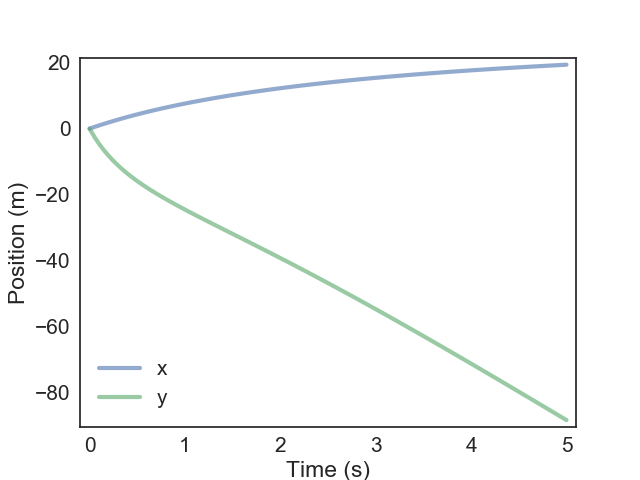

Saving figure to file chap10-fig01.pdf


In [241]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

savefig('chap10-fig01.pdf')

We can plot the velocities the same way.

In [242]:
vxs = system.results.vx
vys = system.results.vy

The x velocity slows down due to drag.  The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

<IPython.core.display.Javascript object>


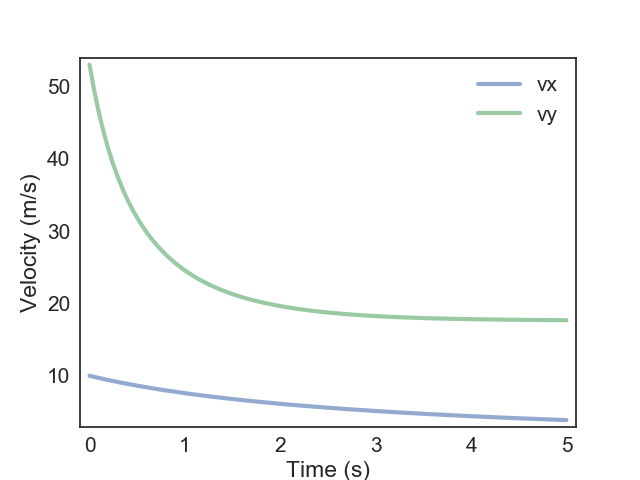

In [243]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

<IPython.core.display.Javascript object>


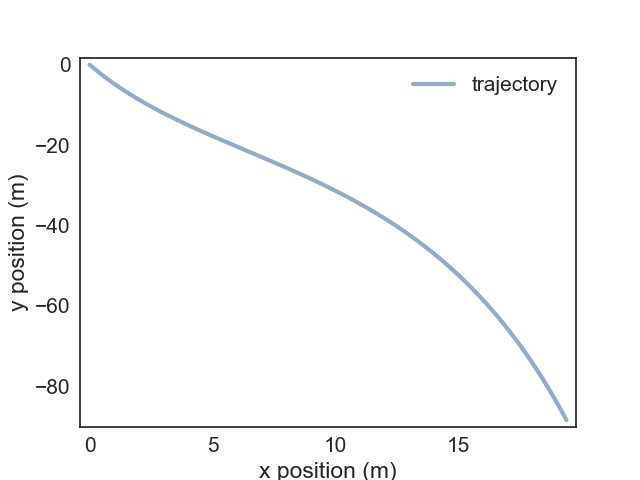

Saving figure to file chap10-fig02.pdf


In [244]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

savefig('chap10-fig02.pdf')

We can also animate the flight of the ball.  If there's an error in the simulation, we can sometimes spot it by looking at animations.

<IPython.core.display.Javascript object>


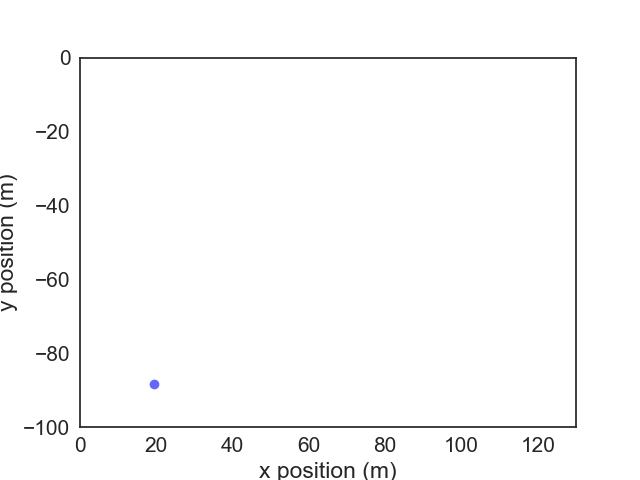

In [232]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 130],
         ylim=[-100, 0],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.05)

Here's a function that encapsulates that code and runs the animation in (approximately) real time.

In [38]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

<IPython.core.display.Javascript object>


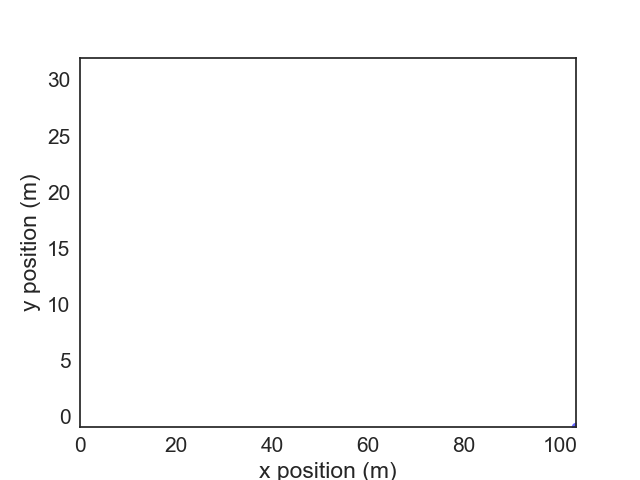

In [39]:
animate2d(system.results.x, system.results.y)

**Exercise:** Run the simulation for a few different launch angles and visualize the results.  Are they consistent with your expectations?

<IPython.core.display.Javascript object>


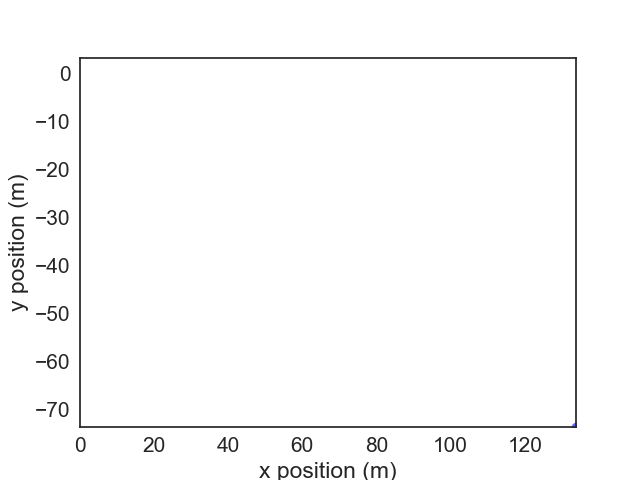

In [40]:
condition.set(angle = 10*degree)
system = make_system(condition)


run_odeint(system, slope_func)
xs = system.results.x
ys = system.results.y

animate2d(system.results.x, system.results.y)

<IPython.core.display.Javascript object>


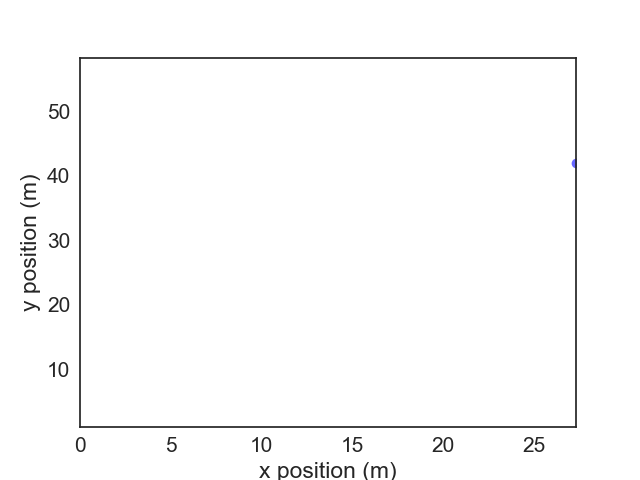

In [41]:
condition.set(angle = 80*degree)
system = make_system(condition)


run_odeint(system, slope_func)
xs = system.results.x
ys = system.results.y

animate2d(system.results.x, system.results.y)

<IPython.core.display.Javascript object>


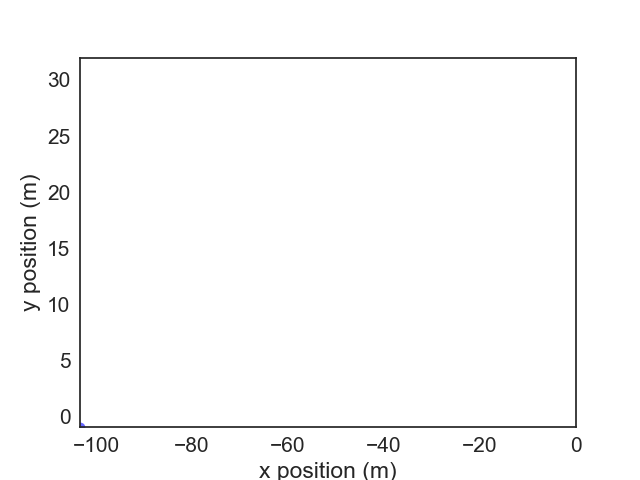

In [42]:
condition.set(angle = 135*degree)
system = make_system(condition)


run_odeint(system, slope_func)
xs = system.results.x
ys = system.results.y

animate2d(system.results.x, system.results.y)

### Finding the range

Next we'll find the time and distance when the ball hits the ground.

In [43]:
condition.set(duration=9*s)
system = make_system(condition)
run_odeint(system, slope_func)
condition

,value
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,135 degree
velocity,40.0 meter / second
duration,9 second


We have to interpolate y to find the landing time, then interpolate x to find the range.

In [44]:
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

Here's the result.

In [45]:
range1 = interpolate_range(system.results)
range1

array(-102.72237868936567)

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

In [46]:
# Hint: rather than modify `condition`, make a copy

condition2 = Condition(condition)
condition2.set(rho = 1 * kg/m**3)
system2 = make_system(condition2)
run_odeint(system2, slope_func)
range2 = interpolate_range(system2.results)
range2

array(-109.07212155238025)

In [47]:
print(range2-range1)

-6.34974286301


Sometimes when I run this the ranges come out positive, and other times they come out negative. Why is that?
Also, it keeps setting condition.rho to 1.0, even though I'm only changing condition2.rho. Why is that happening?

### Optimal launch angle

To find the launch angle that maximizes range, we need a function that takes launch angle and returns range.

In [48]:
condition.set(rho = 1.2 * kg/m**3)

In [49]:
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    return x_range

Let's test `range_func`.

In [50]:
%time range_func(45, condition)

Wall time: 482 ms


array(102.72237868937154)

And sweep through a range of angles.

In [51]:
angles = linspace(30, 60, 11)
sweep = SweepSeries()

for angle in angles:
    x_range = range_func(angle, condition)
    print(angle, x_range)
    sweep[angle] = x_range

30.0 97.0977501638821
33.0 100.0891109308787
36.0 102.12802961010892
39.0 103.23446201852528
42.0 103.42684384914604
45.0 102.72237868937154
48.0 101.1374409438051
51.0 98.68805082659468
54.0 95.3904329706025
57.0 91.26165388910185
60.0 86.32037271133082


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

<IPython.core.display.Javascript object>


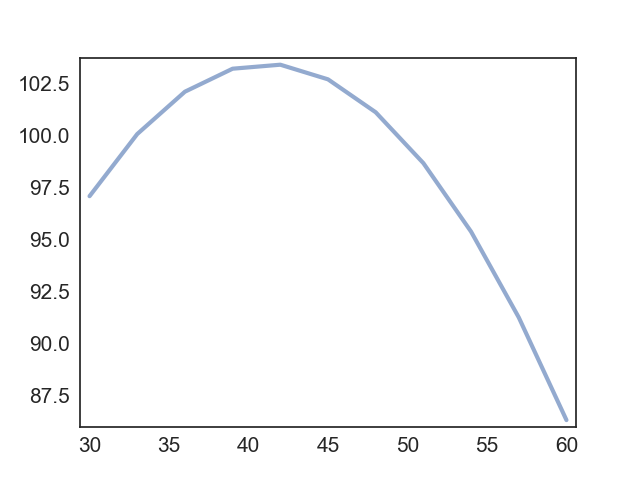

Saving figure to file chap10-fig03.pdf


In [52]:
newfig()
plot(sweep)
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         legend=False)

savefig('chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [53]:
%time res = max_bounded(range_func, [0, 90], condition)

Wall time: 3.39 s


The result is an `OptimizeResult` object.

In [54]:
type(res)

scipy.optimize.optimize.OptimizeResult

With the following variables.

In [55]:
res

     fun: 103.46412723866531
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 41.136394188282573

So the optimal angle is about 41 degrees, and the resulting range is 103 meters.

**Exercise:** Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [56]:
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    print(angle)
    return x_range

In [57]:
res = max_bounded(range_func, [0, 90], condition)
print(res)

45.0
34.3769410125
55.6230589875
21.246117975
41.4051855538
41.236861999
41.1390580958
41.1363941883
41.1367281318
41.1360602448
     fun: 103.46412723866531
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 41.136394188282573


### Turning off units

Each time `range_func` runs, it calls `odeint`, which runs `slope_func` many times.  And each time `slop_func` runs, it checks the units for all computations, which takes some time.  We can speed up the whole process by removing the units from the computation (now that we are satisfied that they are correct).

Because of the way we organized the code, all units are in the `Condition` object, so we can "turn off units" by defining a new `Condition` object with no units:

In [58]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      C_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 7)

Now `range_func` and `max_bounded` are substantially faster.

In [59]:
%time range_func(45, condition)

45
Wall time: 48.1 ms


array(102.72237841710975)

In [60]:
%time res = max_bounded(range_func, [0, 90], condition)

45.0
34.3769410125
55.6230589875
21.246117975
41.4051852323
41.2368620421
41.1390964616
41.1364127407
41.1367466842
41.1360787972
Wall time: 435 ms


### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it launches at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a condition as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [61]:
def height_func(angle, condition):
    
    condition.set(angle = angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    ys = system.results.y
    
    T = interp_inverse(xs, kind='cubic')
    t_wall = T(94.5)
    Y = interpolate(ys, kind='cubic')
    
    return Y(t_wall)

Test your function with a launch angle of 45 degrees:

In [62]:
height_func(45, condition)

array(11.03098394866538)

Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [63]:
res = max_bounded(height_func, [0, 90], condition)
res

     fun: 11.045290303525986
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 44.541455127395977

The following lines compute the height of the ball at the wall, given that it's launched at the optimal angle.

In [64]:
angle = res.x
height = height_func(angle, condition)
height

array(11.045290303525986)

Next, we need to find the height of the ball at the wall, for a given velocity, given that it's launched at the optimal angle.

Write a function called `best_height` that takes velocity and a `Condition` object as parameters.  It should use `max_bounded` to find the optimal launch angle, then compute and the highest possible height of the ball at the wall, for the given velocity.

In [65]:
def best_height(velocity, condition):
    condition.set(velocity = velocity)
    res = max_bounded(height_func, [0, 90], condition)
    angle = res.x
    height = height_func(angle, condition)
    return height
    

Use this code to test `best_height`

In [66]:
best_height(40, condition)

array(11.045290303525986)

Finally, we want to use `fsolve` to find the initial velocity that makes the height of the ball exactly 11 meters when it reaches the wall.

To use `fsolve`, we need an error function that returns 0 when we have the right velocity.  Write a function called `error_func` that takes a velocity and a `Condition` object, uses `best_height` to find the height of the ball at the wall, and returns the difference between the result and the target value (11 meters).

In [69]:
def error_func(velocity, condition):
    height = best_height(velocity, condition)
    error = height - 11
    return error

Test your error function like this:

In [70]:
error_func(40, condition)

0.045290303525986175

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [81]:
min_vel = fsolve(error_func, 40, condition)
min_vel

array([ 39.98869759])

And just to check, run `best_height` with the value you found.  The result should be 11 meters.

In [82]:
best_height(min_vel, condition)

array(11.000000000013193)